In [28]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import skimage
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

from tqdm import tqdm

import pickle

import os
from skimage import io

import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

# Image Import with SKImage and OS

In [2]:
#Set height/width for image resizing, create a Boolean to check whether import is already done for current image size:

missingdataset = False
image_size = 72

In [3]:
# Kaggle "test" data is unlabeled, so we will be performing a train/test split on the "train" data.

labeled_data = 'dogscats/train'
# unlabeled_data = 'dogscats/test'

## Example Cat image:

In [4]:
image = color.rgb2gray(io.imread(labeled_data+'/cat.7.jpg'))

In [5]:
image.shape

(499, 495)

In [6]:
image_resized = resize(image, (image_size, image_size), mode='reflect')

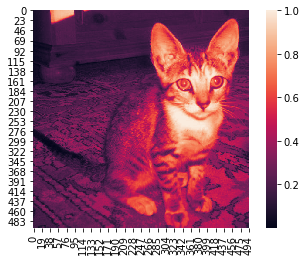

In [7]:
sns.heatmap(image, square=True)

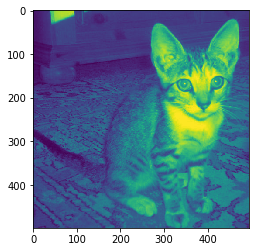

In [8]:
# Matplotlib has its own built-in option

plt.imshow(image)
plt.show()

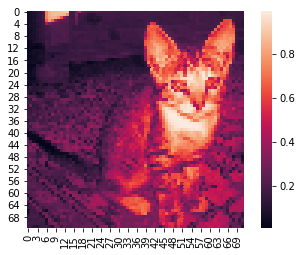

In [9]:
sns.heatmap(image_resized, square=True)

## Functions for Importing Images with Labels Applied:

In [10]:
# Use "cat" as 1, "dog" as 0

def label_image(image):
    animal_label = image.split('.')[-3]
    if animal_label == 'cat':
        return 1
    elif animal_label == 'dog':
        return 0

In [11]:
# Resize each image, then save to a .npy file with a label corresponding to image size:

def import_resize_image(image_size=image_size):
    data = []
    for image in tqdm(os.listdir(labeled_data)):
        label = label_image(image)
        path = os.path.join(labeled_data, image)
        image_number = image.split('.')[0]
        image = resize(color.rgb2gray(io.imread(labeled_data +'/' + image)), (image_size, image_size), mode='constant')
        data.append([np.array(image), np.array(label)])
    np.save('dog_cat_data_{}.npy'.format(image_size), data)

In [12]:
try:
    dataset = np.load('dog_cat_data_{}.npy'.format(image_size))
except FileNotFoundError:
    missingdataset = True

In [13]:
missingdataset

False

In [14]:
# If there is no .npy file of the correct size images in the directory, create one.

if missingdataset == True:
    train_data = import_resize_image()
else:
    pass

In [15]:
dataset = np.load('dog_cat_data_{}.npy'.format(image_size))

In [16]:
dataset[0]

array([array([[0.08203056, 0.18676362, 0.15436868, ..., 0.63885399, 0.6950905 ,
        0.7441331 ],
       [0.0761482 , 0.17720479, 0.10363943, ..., 0.59315962, 0.62118686,
        0.72513739],
       [0.05728733, 0.1464111 , 0.16087483, ..., 0.53842667, 0.65617248,
        0.76647089],
       ...,
       [0.08704764, 0.08970971, 0.11348622, ..., 0.21830033, 0.23998754,
        0.23323373],
       [0.13904201, 0.11240698, 0.0938206 , ..., 0.18277986, 0.21722065,
        0.23323373],
       [0.14302131, 0.10669415, 0.13113379, ..., 0.20259264, 0.2231881 ,
        0.20584472]]),
       array(0)], dtype=object)

### Feature Set/Label Set

In [17]:
X = []
y = []

for features, label in dataset:
    X.append(features)
    y.append(label)

In [18]:
X = np.array(X).reshape(-1, image_size, image_size, 1)

In [37]:
y = np.array(y).reshape(-1, 1)

In [38]:
y

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [39]:
X[0].shape

(72, 72, 1)

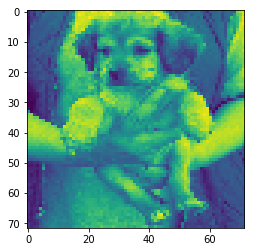

In [40]:
plt.imshow(X[0].reshape(image_size, image_size))
plt.show()

### Pickling

In [51]:
pickle_features = False


if pickle_features == True:
    pickle_out = open("X.pickle","wb")
    pickle.dump(X, pickle_out)
    pickle_out.close()

    pickle_out = open("y.pickle","wb")
    pickle.dump(y, pickle_out)
    pickle_out.close()

    pickle_in = open("X.pickle","rb")
    X = pickle.load(pickle_in)

    pickle_in = open("y.pickle","rb")
    y = pickle.load(pickle_in)

### Train-Test Split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=28)

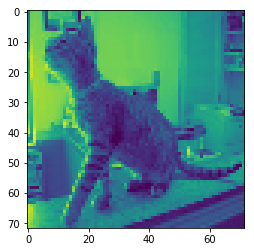

In [43]:
plt.imshow(X_train[0].reshape(image_size, image_size))
plt.show()

# Models 

## Keras Model 1

Conv2D ( (256, (3, 3)) + MaxPooling(2, 2) ) x2, Dense 64

In [44]:
model_1 = Sequential()

model_1.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Flatten())

model_1.add(Dense(64))

model_1.add(Dense(1))
model_1.add(Activation('sigmoid'))

model_1.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])

In [45]:
model_1.fit(X_train, y_train, batch_size=32, epochs=3)

Epoch 1/3
20000/20000 [==============================] - 886s 44ms/step - loss: 0.6825 - acc: 0.5783
Epoch 2/3
20000/20000 [==============================] - 885s 44ms/step - loss: 0.6092 - acc: 0.6723
Epoch 3/3
20000/20000 [==============================] - 879s 44ms/step - loss: 0.5524 - acc: 0.7237


In [50]:
score_1 = model_1.evaluate(X_test, y_test, batch_size=32)
print(score_1)

5000/5000 [==============================] - 63s 13ms/step
[0.5698342646598816, 0.7124]


#### 44 minutes, 10 seconds.

## Keras Model 2 - Larger Convolution Window on 1st Layer

Conv2D (256, (3, 3)) + MaxPooling(2, 2), Conv2D (256, (5, 5)) + MaxPooling(2, 2), Dense 64

In [46]:
model_2 = Sequential()

model_2.add(Conv2D(256, (5, 5), input_shape=X.shape[1:]))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Flatten())

model_2.add(Dense(64))

model_2.add(Dense(1))
model_2.add(Activation('sigmoid'))

model_2.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])

model_2.fit(X_train, y_train, batch_size=32, epochs=3)

Epoch 1/3
20000/20000 [==============================] - 859s 43ms/step - loss: 0.6975 - acc: 0.5034
Epoch 2/3
20000/20000 [==============================] - 875s 44ms/step - loss: 0.6817 - acc: 0.5633
Epoch 3/3
20000/20000 [==============================] - 852s 43ms/step - loss: 0.6598 - acc: 0.6079


In [52]:
score_2 = model_2.evaluate(X_test, y_test, batch_size=32)
print(score_2)

5000/5000 [==============================] - 62s 12ms/step
[0.6569680589675904, 0.6252]


#### 43 minutes, 7 seconds.

## Keras Model 3 - 3 Convolution Layers

Conv2D ( (256, (3, 3)) + MaxPooling(2, 2) ) x3, Dense 64, 

In [53]:
model_3 = Sequential()

model_3.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Flatten())

model_3.add(Dense(64))

model_3.add(Dense(1))
model_3.add(Activation('sigmoid'))

model_3.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])

model_3.fit(X_train, y_train, batch_size=32, epochs=3)

Epoch 1/3
20000/20000 [==============================] - 1004s 50ms/step - loss: 0.6660 - acc: 0.5916
Epoch 2/3
20000/20000 [==============================] - 1065s 53ms/step - loss: 0.5565 - acc: 0.7129
Epoch 3/3
20000/20000 [==============================] - 1060s 53ms/step - loss: 0.4767 - acc: 0.7729


In [54]:
score_3 = model_3.evaluate(X_test, y_test, batch_size=32)
print(score_3)

5000/5000 [==============================] - 70s 14ms/step
[0.4568680475234985, 0.781]


#### 52 minutes, 10 seconds.

## Keras Model 4 - Dropout 0.1

Conv2D ( (256, (3, 3)) + Dropout(0.1) + MaxPooling(2, 2) ) x2, Dense 64

In [55]:
model_4 = Sequential()

model_4.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_4.add(Dropout(0.1))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_4.add(Dropout(0.1))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Flatten())

model_4.add(Dense(64))

model_4.add(Dense(1))
model_4.add(Activation('sigmoid'))

model_4.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])

model_4.fit(X_train, y_train, batch_size=32, epochs=3)

Epoch 1/3
20000/20000 [==============================] - 1104s 55ms/step - loss: 0.6942 - acc: 0.5514
Epoch 2/3
20000/20000 [==============================] - 1109s 55ms/step - loss: 0.6575 - acc: 0.6137
Epoch 3/3
20000/20000 [==============================] - 1116s 56ms/step - loss: 0.6364 - acc: 0.6452


In [56]:
score_4 = model_4.evaluate(X_test, y_test, batch_size=32)
print(score_4)

5000/5000 [==============================] - 64s 13ms/step
[0.6268639585494995, 0.6564]


#### 55 minutes, 30 seconds.

## Keras Model 5 - 3 Layers w/Dropout 0.1

Conv2D ( (256, (3, 3)) + Dropout(0.1) + MaxPooling(2, 2) ) x2, Dense 64

In [65]:
model_5 = Sequential()

model_5.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Dropout(0.1))

model_5.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Dropout(0.1))

model_5.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Flatten())

model_5.add(Dense(64))

model_5.add(Dense(1))
model_5.add(Activation('sigmoid'))

model_5.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])

model_5.fit(X_train, y_train, batch_size=32, epochs=3)

Epoch 1/3
20000/20000 [==============================] - 1044s 52ms/step - loss: 0.6725 - acc: 0.5843
Epoch 2/3
20000/20000 [==============================] - 1655s 83ms/step - loss: 0.5630 - acc: 0.7131
Epoch 3/3
20000/20000 [==============================] - 1045s 52ms/step - loss: 0.4780 - acc: 0.7733


In [66]:
score_5 = model_5.evaluate(X_test, y_test, batch_size=32)
print(score_5)

5000/5000 [==============================] - 68s 14ms/step
[0.4413045980453491, 0.7958]


#### 62 minutes, 24 seconds.

## Keras Model 6 - 3 Layers w/Dropout 0.2 between each

Conv2D ( (256, (3, 3)) + Dropout(0.1) + MaxPooling(2, 2) ) x2, Dense 64

In [67]:
model_6 = Sequential()

model_6.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))

model_6.add(Dropout(0.2))

model_6.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))

model_6.add(Dropout(0.2))

model_6.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))

model_6.add(Flatten())

model_6.add(Dense(64))

model_6.add(Dense(1))
model_6.add(Activation('sigmoid'))

model_6.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])

model_6.fit(X_train, y_train, batch_size=32, epochs=3)

Epoch 1/3
20000/20000 [==============================] - 1052s 53ms/step - loss: 0.6906 - acc: 0.5271
Epoch 2/3
20000/20000 [==============================] - 1044s 52ms/step - loss: 0.6651 - acc: 0.5951
Epoch 3/3
20000/20000 [==============================] - 1040s 52ms/step - loss: 0.5810 - acc: 0.6985


In [68]:
score_6 = model_6.evaluate(X_test, y_test, batch_size=32)
print(score_6)

5000/5000 [==============================] - 68s 14ms/step
[0.520741499710083, 0.7416]


#### 52 minutes, 17 seconds.

## Keras Model 7 - 4 Layers

Conv2D ( (256, (3, 3)) + Dropout(0.1) + MaxPooling(2, 2) ) x2, Dense 64

In [71]:
model_7 = Sequential()

model_7.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

model_7.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

model_7.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

model_7.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

model_7.add(Flatten())

model_7.add(Dense(64))

model_7.add(Dense(1))
model_7.add(Activation('sigmoid'))

model_7.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])

model_7.fit(X_train, y_train, batch_size=32, epochs=3)

Epoch 1/3
20000/20000 [==============================] - 998s 50ms/step - loss: 0.6784 - acc: 0.5656
Epoch 2/3
20000/20000 [==============================] - 993s 50ms/step - loss: 0.5928 - acc: 0.6848
Epoch 3/3
20000/20000 [==============================] - 993s 50ms/step - loss: 0.4786 - acc: 0.7746


In [72]:
score_7 = model_7.evaluate(X_test, y_test, batch_size=32)
print(score_7)

5000/5000 [==============================] - 68s 14ms/step
[0.48277338962554933, 0.7752]


#### 49 minutes, 45 seconds.

## Keras Model 8 - 3 Layers, 512 neurons each

Conv2D ( (256, (3, 3)) + Dropout(0.1) + MaxPooling(2, 2) ) x2, Dense 64

In [73]:
model_8 = Sequential()

model_8.add(Conv2D(512, (3, 3), input_shape=X.shape[1:]))
model_8.add(Activation('relu'))
model_8.add(MaxPooling2D(pool_size=(2, 2)))

model_8.add(Conv2D(512, (3, 3), input_shape=X.shape[1:]))
model_8.add(Activation('relu'))
model_8.add(MaxPooling2D(pool_size=(2, 2)))

model_8.add(Conv2D(512, (3, 3), input_shape=X.shape[1:]))
model_8.add(Activation('relu'))
model_8.add(MaxPooling2D(pool_size=(2, 2)))

model_8.add(Flatten())

model_8.add(Dense(64))

model_8.add(Dense(1))
model_8.add(Activation('sigmoid'))

model_8.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])

model_8.fit(X_train, y_train, batch_size=32, epochs=3)

Epoch 1/3
20000/20000 [==============================] - 2956s 148ms/step - loss: 0.6840 - acc: 0.5823
Epoch 2/3
20000/20000 [==============================] - 2949s 147ms/step - loss: 0.5728 - acc: 0.7062
Epoch 3/3
20000/20000 [==============================] - 2946s 147ms/step - loss: 0.4866 - acc: 0.7684


In [74]:
score_8 = model_8.evaluate(X_test, y_test, batch_size=32)
print(score_8)

5000/5000 [==============================] - 201s 40ms/step
[0.4663590823173523, 0.785]


#### 157 minutes, 32 seconds.

## Keras Model 9 - 4 Layers, 512 neurons each, dropout 0.1

Conv2D ( (256, (3, 3)) + Dropout(0.1) + MaxPooling(2, 2) ) x2, Dense 64

In [75]:
model_9 = Sequential()

model_9.add(Conv2D(512, (3, 3), input_shape=X.shape[1:]))
model_9.add(Activation('relu'))
model_9.add(MaxPooling2D(pool_size=(2, 2)))

model_9.add(Dropout(0.1))

model_9.add(Conv2D(512, (3, 3), input_shape=X.shape[1:]))
model_9.add(Activation('relu'))
model_9.add(MaxPooling2D(pool_size=(2, 2)))

model_9.add(Dropout(0.1))

model_9.add(Conv2D(512, (3, 3), input_shape=X.shape[1:]))
model_9.add(Activation('relu'))
model_9.add(MaxPooling2D(pool_size=(2, 2)))

model_9.add(Dropout(0.1))

model_9.add(Conv2D(512, (3, 3), input_shape=X.shape[1:]))
model_9.add(Activation('relu'))
model_9.add(MaxPooling2D(pool_size=(2, 2)))

model_9.add(Flatten())

model_9.add(Dense(64))

model_9.add(Dense(1))
model_9.add(Activation('sigmoid'))

model_9.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])

model_9.fit(X_train, y_train, batch_size=32, epochs=3)

Epoch 1/3
20000/20000 [==============================] - 3194s 160ms/step - loss: 8.0414 - acc: 0.4995
Epoch 2/3
20000/20000 [==============================] - 3194s 160ms/step - loss: 8.0615 - acc: 0.4998
Epoch 3/3
20000/20000 [==============================] - 3195s 160ms/step - loss: 8.0615 - acc: 0.4998


In [76]:
score_9 = model_9.evaluate(X_test, y_test, batch_size=32)
print(score_9)

5000/5000 [==============================] - 203s 41ms/step
[8.049376914978028, 0.5006]


#### 179 minutes, 43 seconds.

## Keras Model 10 - 4 Layers, 128 neurons each, dropout 0.1

Conv2D ( (256, (3, 3)) + Dropout(0.1) + MaxPooling(2, 2) ) x2, Dense 64

In [85]:
model_10 = Sequential()

model_10.add(Conv2D(128, (3, 3), input_shape=X.shape[1:]))
model_10.add(Activation('relu'))
model_10.add(MaxPooling2D(pool_size=(2, 2)))

model_10.add(Dropout(0.1))

model_10.add(Conv2D(128, (3, 3), input_shape=X.shape[1:]))
model_10.add(Activation('relu'))
model_10.add(MaxPooling2D(pool_size=(2, 2)))

model_10.add(Dropout(0.1))

model_10.add(Conv2D(128, (3, 3), input_shape=X.shape[1:]))
model_10.add(Activation('relu'))
model_10.add(MaxPooling2D(pool_size=(2, 2)))

model_10.add(Dropout(0.1))

model_10.add(Conv2D(128, (3, 3), input_shape=X.shape[1:]))
model_10.add(Activation('relu'))
model_10.add(MaxPooling2D(pool_size=(2, 2)))

model_10.add(Flatten())

model_10.add(Dense(64))

model_10.add(Dense(1))
model_10.add(Activation('sigmoid'))

model_10.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])

model_10.fit(X_train, y_train, batch_size=32, epochs=3)

Epoch 1/3
20000/20000 [==============================] - 430s 22ms/step - loss: 0.6737 - acc: 0.5722
Epoch 2/3
20000/20000 [==============================] - 433s 22ms/step - loss: 0.5683 - acc: 0.7083
Epoch 3/3
20000/20000 [==============================] - 429s 21ms/step - loss: 0.4818 - acc: 0.7682


In [86]:
score_10 = model_10.evaluate(X_test, y_test, batch_size=32)
print(score_10)

5000/5000 [==============================] - 26s 5ms/step
[0.48934580640792846, 0.7548]


#### 21 minutes, 34 seconds.

# Results

In [87]:
scores = [score_1, score_2, score_3, score_4, score_5, score_6, score_7, score_8, score_9, score_10]

In [88]:
for i, score in enumerate(scores):
    print("Model {} (binary cross-entropy, accuracy):".format(i+1), score)

Model 1 (binary cross-entropy, accuracy): [0.5698342646598816, 0.7124]
Model 2 (binary cross-entropy, accuracy): [0.6569680589675904, 0.6252]
Model 3 (binary cross-entropy, accuracy): [0.4568680475234985, 0.781]
Model 4 (binary cross-entropy, accuracy): [0.6268639585494995, 0.6564]
Model 5 (binary cross-entropy, accuracy): [0.4413045980453491, 0.7958]
Model 6 (binary cross-entropy, accuracy): [0.520741499710083, 0.7416]
Model 7 (binary cross-entropy, accuracy): [0.48277338962554933, 0.7752]
Model 8 (binary cross-entropy, accuracy): [0.4663590823173523, 0.785]
Model 9 (binary cross-entropy, accuracy): [8.049376914978028, 0.5006]
Model 10 (binary cross-entropy, accuracy): [0.48934580640792846, 0.7548]


The model with the highest accuracy is the 3-layer model with 0.1 dropout between each of those layers. Model 5 took just over an hour to finish training, while the next best performer, model 3, took 52 minutes (no dropout layers).

Increasing the number of neurons had a huge effect on time taken to run.

However, a narrower, deeper neural net (model 10) provided rather decent results in significantly reduced time.

This is twice the number of iterations for the challenge, but it seems we are still just scratching the surface.